In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"  
import jax
from jax import numpy as np
from jax import vmap
import optax
import numpy as onp
from typing import Callable, Tuple
import sys
import argparse

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.75'

# Network

In [2]:
import haiku as hk
import jax.numpy as np
import numpy as onp
from typing import Optional, Tuple, Callable, Union
import jax
from jax import vmap
from dataclasses import dataclass

###################################################################################################################
def construct_mlp_layers(
    n_hidden: int,
    n_neurons: int, 
    act: Callable[[np.ndarray], np.ndarray], 
    output_dim: int,
    residual_blocks: bool = True 
) -> list:
    """Make a list containing the layers of an MLP.

    Args:
        n_hidden: Number of hidden layers in the MLP.
        n_neurons: Number of neurons per hidden layer.
        act: Activation function.
        output_dim: Dimension of the output.
        residual_blocks: Whether or not to use residual blocks.
    """
    layers = [] 

    resid_act = lambda x: x + act(x)
    for layer in range(n_hidden):
        ## construct layer
        if layer == 0 or not residual_blocks:
            layers = layers + [
                    hk.Linear(n_neurons),
                    act
                ]
        else:
            layers = layers + [
                    hk.Linear(n_neurons),
                    resid_act
                ]


    ## construct output layer
    layers = layers + [hk.Linear(output_dim)] 
    return layers






###################################################################################################################
def construct_score_network(
    d: int,
    n_hidden: int,
    n_neurons: int,
    act: Callable[[np.ndarray], np.ndarray],
    residual_blocks: bool = True,
    is_gradient: bool = False
) -> Tuple[Callable, Callable]:
    """Construct a score network for a simpler system
    that does not consist of interacting particles.

    Args:
        d: System dimension.
        n_hidden: Number of hidden layers in the network.
        n_neurons: Number of neurons per layer.
        act: Activation function.
        residual_blocks: Whether or not to use residual blocks.
        is_gradient: Whether or not to compute the score as the gradient of a potential.
    """
    output_dim = 1 if is_gradient else d 
    net = lambda x: hk.Sequential(
        construct_mlp_layers(n_hidden, n_neurons, act, output_dim, residual_blocks)
    )(x)

    if is_gradient:
        potential = lambda x: np.squeeze(net(x)) 
        score = jax.grad(potential)
        return hk.without_apply_rng(hk.transform(score)), \
                hk.without_apply_rng(hk.transform(potential))
    else:
        return hk.without_apply_rng(hk.transform(net)), None


# Losses

In [3]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as np
from typing import Tuple, Callable, Union, Optional
from jax import jit, vmap, value_and_grad
from jaxopt.linear_solve import solve_cg
from functools import partial
import haiku as hk
import optax


#######################################################################################################################
def grad_log_rho0(
    sample: np.ndarray,
    sig0: float,
    mu0: np.ndarray
) -> np.ndarray:
    """Compute the initial potential. Assumed to be an isotropic Gaussian."""
    return -(sample - mu0) / sig0**2

def rho0(
    sample: np.ndarray,
    sig0: float = 1,
    mu0: np.ndarray = 0
) -> np.ndarray:
    """Compute the initial potential. Assumed to be an isotropic Gaussian."""
    sig0 = 1
    mu0 = 0
    return np.exp(-(sample - mu0)**2 / (2 * sig0**2))



#######################################################################################################################
@partial(jit, static_argnums=(4, 5, 7))
def init_loss(
    params: np.ndarray,
    samples: np.ndarray,
    sig0: float,
    mu0: np.ndarray,
    apply_score: Callable[[hk.Params, np.ndarray, Optional[float]], np.ndarray],
    time_dependent: bool = False, 
    frame_end: float = 0,
    nt: int = 0
) -> np.ndarray:
    """Compute the initial loss, assuming access to \nabla \log \rho0."""

    grad_log_rho_evals = vmap(
        lambda sample:  D * grad_log_rho0(sample, sig0, mu0)
    )(samples) 
    
    score_evals = vmap(
        lambda sample:   apply_score(params, sample)
    )(samples)

    @jax.jit
    def levypart(sample):
        sample = np.array(sample)   
        lambdaj_ri_matrix = lambdaj[:, None] * ri[None, :] 
        lambdaj_ri_matrix = np.expand_dims(lambdaj_ri_matrix, axis=2)
        expanded_samples = sample - lambdaj_ri_matrix 
        all_scores = (jax.vmap(jax.vmap(rho0))(expanded_samples)).squeeze()
        scores_sumj = np.mean(all_scores, axis=0)
        return np.mean(scores_sumj * ri * N_ri * 7 * sig_jump) / rho0(sample)

    LEVYpart = vmap(levypart, in_axes=0)(samples)
    score = np.sum(   ( score_evals - (grad_log_rho_evals - LEVYpart) )**2) \
            / np.sum((grad_log_rho_evals-LEVYpart)**2)

    return score


  



#######################################################################################################################
@jit
def compute_grad_norm(
    grads: hk.Params
) -> float:
    """ Computes the norm of the gradient, where the gradient is input
    as an hk.Params object (treated as a PyTree)."""
    flat_params = ravel_pytree(grads)[0]
    return np.linalg.norm(flat_params) / np.sqrt(flat_params.size)




#######################################################################################################################
@partial(jit, static_argnums=(2, 3))
def update(
    params: hk.Params, 
    opt_state: optax.OptState, 
    opt: optax.GradientTransformation,
    loss_func: Callable[[hk.Params], float],
    loss_func_args: Tuple = tuple(), 
) -> Tuple[hk.Params, optax.OptState, float, hk.Params]:
    """Update the neural network.

    Args:
        params: Parameters to optimize over.
        opt_state: State of the optimizer.
        opt: Optimizer itself.
        loss_func: Loss function for the parameters.
    """
    loss_value, grads = value_and_grad(loss_func)(params, *loss_func_args)
    
    updates, opt_state = opt.update(grads, opt_state, params=params) 
    new_params = optax.apply_updates(params, updates) 
    return new_params, opt_state, loss_value, grads


# Updata

In [4]:
from jax import jit, vmap
import jax
from functools import partial
import jax.numpy as np
import numpy as onp
import haiku as hk
from typing import Callable, Tuple, Union

#######################################################################################################################
@partial(jit, static_argnums=(5, 6)) 
def update_particles(
    particle_pos: np.ndarray,
    t: float,
    params: hk.Params,
    D: Union[np.ndarray, float], 
    dt: float,
    forcing: Callable[[np.ndarray, float], np.ndarray], 
    apply_score: Callable[[hk.Params, np.ndarray], np.ndarray], 
    mask: np.ndarray = None
) -> np.ndarray:
    """Take a forward Euler step and update the particles."""
    
    if mask is not None:
        score_term = -mask * apply_score(params, particle_pos)
    else:
        score_term = -apply_score(params, particle_pos)

    return particle_pos + dt*(forcing(particle_pos, t) + score_term)



#######################################################################################################################
@partial(jit, static_argnums=(5, 6))
def update_particles_EM(
    particle_pos: np.ndarray,
    t: float,
    D_sqrt: Union[np.ndarray, float], 
    dt: float,
    key: np.ndarray, 
    forcing: Callable[[np.ndarray, float], np.ndarray],
    noisy: bool = True,
    mask: np.ndarray = None,
) -> np.ndarray:
    """Take a step forward via Euler-Maruyama to update the particles."""

    if noisy:
        noise = np.sqrt(2*dt) * jax.random.normal(key, shape=particle_pos.shape)
        if mask is not None:
            brownian = -D_sqrt * mask * noise
        else:
            brownian = -D_sqrt * noise

        return particle_pos + dt*forcing(particle_pos, t) + brownian
    else:
        return particle_pos + dt*forcing(particle_pos, t)



#######################################################################################################################
def rollout_EM_trajs(
    x0s: np.ndarray,
    nsteps: int,
    t0: float,
    dt: float,
    key: np.ndarray,
    forcing: Callable[[np.ndarray, float], np.ndarray],
    D_sqrt: Union[np.ndarray, float],
    noisy: bool = True
) -> np.ndarray:
    """Given a set of initial conditions, create a stochastic trajectory 
    via Euler-Maruyama. Useful for constructing a baseline against which to compare
    the moments.

    Args:
    ------
    x0s: Initial condition. Dimension = n x d where n is the number of samples 
         and d is the dimension of the system.
    nsteps: Number of steps of Euler-Maruyama to take.
    t0: initial time.
    dt: Timestep.
    key: jax PRNG key.
    forcing: Forcing to apply to the particles.
    D_sqrt: Square root of the diffusion matrix.
    """
    n, d = x0s.shape
    trajs = onp.zeros((nsteps+1, n, d)) 
    trajs[0] = x0s
    step_sample = \
            lambda sample, t, key: update_particles_EM(sample, t, D_sqrt, 
                                                       dt, key, forcing, noisy)
    step_samples = vmap(step_sample, in_axes=(0, None, 0), out_axes=0)

    
    for curr_step in tqdm(range(nsteps)):
        t = t0 + curr_step*dt
        keys = jax.random.split(key, num=n) 
        trajs[curr_step+1] = step_samples(trajs[curr_step], t, keys)
        key = keys[-1] 

    return trajs, key 


# Rollouts

In [5]:
from jax import jit, vmap
from jax.tree_util import tree_map
import jax
from functools import partial
import jax.numpy as np
import numpy as onp
import haiku as hk
from typing import Callable, Tuple, Union
import optax
import dill as pickle
import time
from tqdm import tqdm
from jaxlib.xla_extension import Device

Time = float


def fit_initial_condition(
    n_max_opt_steps: int, 
    ltol: float, 
    params: hk.Params, 
    sig0: float,
    mu0: np.ndarray,
    score_network: Callable[[hk.Params, np.ndarray], np.ndarray],
    opt: optax.GradientTransformation,
    opt_state: optax.OptState,
    samples: np.ndarray,
    time_dependent: bool = False,
    frame_end: float = 0,
    nt: int = 0
) -> hk.Params:
    """Fit the score for the initial condition.

    Args:
        n_opt_steps: Number of optimization steps before the norm of the gradient 
                     is checked.
        gtol: Tolerance on the norm of the gradient.
        ltol: Tolerance on the relative error.
        params: Parameters to optimize over.
        sig0: Standard deviation of the target initial condition.
        mu0: Mean of the target initial condition.
        score_network: Function mapping parameters and a sample to the network output.
        opt: Optimizer.
        opt_state: State of the optimizer.
        samples: Samples to optimizer over.
    """
    
    apply_score = score_network.apply 
    loss_func = lambda params: \
            init_loss(params, samples, sig0, mu0, apply_score, 
                             time_dependent, frame_end, nt)

    loss_val = np.inf
    try:
        with tqdm(range(n_max_opt_steps)) as pbar:
            pbar.set_description("Initial optimization")
            for curr_step in pbar:
                try:
                    params, opt_state, loss_val, grads = update(params, opt_state, opt, loss_func)
                    pbar.set_postfix(loss=loss_val)
                    if loss_val < ltol:
                        break
                except Exception as e:
                    print(f"Error at step {curr_step}: {e}")
                    break
    except Exception as e:
        print(f"Error initializing the progress bar: {e}")

    return params


# Drifts


In [6]:
from jax import vmap
from jax.lax import stop_gradient
import jax.numpy as np
from typing import Callable, Tuple



############################################################################################################################
def exapmle1(
    x: np.ndarray,
    t: float,
    # gamma: float
    kappa: float,
    eta: float
) -> np.ndarray:
    del t
    return (kappa * (eta - x) )


# SBTM-SIM


In [7]:
from dataclasses import dataclass
from typing import Callable, Tuple, Union
import haiku as hk
import jax
import numpy as onp
from jaxlib.xla_extension import Device
import optax


State = onp.ndarray
Time = float


@dataclass
class SBTMSim:
    """
    Base class for all SBTM simulations.
    Contains simulation parameters common to all SBTM approaches.
    """
    # initial condition fitting
    n_max_init_opt_steps: int
    init_learning_rate: float
    init_ltol: float
    sig0: float
    mu0: onp.ndarray

    # system parameters
    drift: Callable[[State, Time], State]
    force_args: Tuple
    amp: Callable[[Time], float]
    freq: float
    dt: float
    D: onp.ndarray
    D_sqrt: onp.ndarray
    n: int
    d: int
    N: int

    # timestepping
    ltol: float
    gtol: float
    n_opt_steps: int
    learning_rate: float

    # network parameters
    n_hidden: int
    n_neurons: int
    act: Callable[[State], State]
    residual_blocks: bool
    interacting_particle_system: bool

    # general simulation parameters
    key: onp.ndarray
    params_list: list
    all_samples: dict

    # output information
    output_folder: str
    output_name: str


    def __init__(self, data_dict: dict) -> None:
        self.__dict__ = data_dict.copy()

    def initialize_forcing(self) -> None:
        self.forcing = lambda x, t: self.drift(x, t, *self.force_args)

    def initialize_network_and_optimizer(self) -> None:
        """Initialize the network parameters and optimizer."""
        if self.interacting_particle_system:
            self.score_network, self.potential_network = \
                    construct_interacting_particle_system_network(
                            self.n_hidden, 
                            self.n_neurons, 
                            self.N, 
                            self.d, 
                            self.act, 
                            self.residual_blocks
                        )

            example_x = onp.zeros(self.N*self.d) 
        else:
            self.score_network, self.potential_network= \
                construct_score_network(
                    self.d,
                    self.n_hidden,
                    self.n_neurons,
                    self.act,
                    is_gradient=False
                )
            
            example_x = onp.zeros(self.d) 
        self.key, sk = jax.random.split(self.key) 
        init_params = self.score_network.init(self.key, example_x) 
        self.params_list = [init_params] 


        network_size = jax.flatten_util.ravel_pytree(init_params)[0].size 
        print(f'Number of parameters: {network_size}')
        print(f'Number of parameters needed for overparameterization: ' \
                + f'{self.n*example_x.size}')

        # set up the optimizer
        self.opt = optax.radam(self.learning_rate) 
        self.opt_state = self.opt.init(init_params) 

        # set up batching for the score
        self.batch_score = jax.vmap(self.score_network.apply, in_axes=(None, 0))

    def fit_init(self, cpu: Device, gpu: Device) -> None:
        """Fit the initial condition."""
        # draw samples
        samples_shape = (self.n, self.N*self.d) 
        init_samples = self.sig0*onp.random.randn(*samples_shape) + self.mu0[None, :] 

        # set up optimizer
        init_params = jax.device_put(self.params_list[0], gpu) 
        opt = optax.adabelief(self.init_learning_rate) 
        opt_state = opt.init(init_params)

        init_params = fit_initial_condition(
                            self.n_max_init_opt_steps,
                            self.init_ltol,
                            init_params,
                            self.sig0,
                            self.mu0,
                            self.score_network,
                            opt,
                            opt_state,
                            init_samples
                        )


        self.params_list = [jax.device_put(init_params, device=cpu)] 
        self.all_samples = {'SDE': [init_samples], 'learned': [init_samples]}


# SBTM-SEQUENTIAL

In [8]:
from dataclasses import dataclass
import jax
import jax.numpy as np
from jax import vmap
import numpy as onp
import dill as pickle
import time
from jaxlib.xla_extension import Device
from haiku import Params
from typing import Tuple


@dataclass
class SequentialSBTM(SBTMSim): 
    n_time_steps: int
    use_SDE: bool
    use_ODE: bool
    save_fac: int 
    store_fac: int 
    means: dict
    covs: dict 
    entropies: list 
    mask: np.ndarray


    def setup_loss(self):
        """Define the loss function. """
        raise NotImplementedError("Please implement in the inheriting class.") 


    
    def setup_loss_fn_args(self, gpu: Device) -> Tuple:
        """Define the arguments to the loss function other than parameters."""
        raise NotImplementedError("Please implement in the inheriting class.")
        

    def setup_batched_steppers(self):
        """Construct convenience functions to step the particles."""
        self.step_learned = vmap(
                lambda params, t, sample: update_particles(
                    sample, 
                    t, 
                    params, 
                    self.D, 
                    self.dt,  
                    self.forcing, 
                    self.score_network.apply,
                    self.mask
                ),
                in_axes=(None, None, 0),
                out_axes=0
        )

        self.step_SDE = vmap(
                lambda t, sample, key: update_particles_EM(
                    sample, 
                    t, 
                    self.D_sqrt, 
                    self.dt, 
                    key,  
                    self.forcing,
                    True,
                    self.mask
                ),
                in_axes=(None, 0, 0),
                out_axes=0
        )

    def step_samples(
        self,
        step,
        params: Params,
        t: float,
        samples: np.ndarray,
        SDE_samples: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Step and save both the SDE and ODE samples."""
        # step learned and SDE particles
        samples = self.step_learned(params, t, samples)
        keys = jax.random.split(self.key, num=self.n)
        SDE_samples = self.step_SDE(t, SDE_samples, keys)
        self.key = keys[-1]

        # save new samples
        if (step+1) % self.store_fac == 0:
            self.all_samples['learned'].append(onp.array(samples))
            self.all_samples['SDE'].append(onp.array(SDE_samples))

        return samples, SDE_samples


    def setup_learning_samples(
        self,
        samples: np.ndarray,
        SDE_samples: np.ndarray
    ) -> Tuple[np.ndarray]:
        """Set up samples to optimize over."""
        if self.use_ODE and self.use_SDE:
            opt_samples = (np.vstack((samples, SDE_samples)),)
        elif self.use_ODE:
            opt_samples = (samples,)
        elif self.use_SDE:
            opt_samples = (SDE_samples,)
        else:
            raise ValueError('Need to specify learning from ODE or SDE.')

        return opt_samples


    def compute_moments_and_entropy_production(
        self,
        params: Params,
        t: float,
        samples: np.ndarray, 
        SDE_samples: np.ndarray
    ) -> None:
        ## entropy
        self.entropies.append(
                compute_entropy_rate(samples, t, params, self.D, self.forcing, 
                                     self.score_network, noise_free=False, div=True)
            )

        ## moments
        self.means['SDE'].append(np.mean(SDE_samples, axis=0))
        self.covs['SDE'].append(np.cov(SDE_samples, rowvar=False))

        self.means['learned'].append(np.mean(samples, axis=0))
        self.covs['learned'].append(np.cov(samples, rowvar=False))


    def solve_fpe_sequential(self, cpu: Device, gpu: Device):
        self.setup_loss()
        self.setup_batched_steppers()
        nt = len(self.params_list) - 1

        
        params = jax.device_put(self.params_list[-1], gpu) 
        opt_state = jax.device_put(self.opt_state, gpu)
        samples = jax.device_put(self.all_samples['learned'][-1], gpu) 
        SDE_samples = jax.device_put(self.all_samples['SDE'][-1], gpu) 


        with tqdm(range(self.n_time_steps)) as pbar: 
            for step in pbar:
                t = (nt*self.store_fac + step)*self.dt
                pbar.set_description(f"Dynamics: t={t:.3f}") 

                samples, SDE_samples = self.step_samples(step, params, t, samples, SDE_samples) 
                opt_samples = self.setup_learning_samples(samples, SDE_samples)

                ## perform the optimization
                loss_value, grad_norm = np.inf, np.inf
                num_steps_taken = 0
                while (grad_norm > self.gtol):
                    for curr_opt_step in range(self.n_opt_steps): 
                        loss_func_args = opt_samples + self.setup_loss_fn_args(gpu)
                        start_time = time.time()
                        params, opt_state, loss_value, grads \
                                = update(
                                        params, 
                                        opt_state, 
                                        self.opt, 
                                        self.loss_func, 
                                        loss_func_args
                                    )
                        end_time = time.time()

                    grad_norm = compute_grad_norm(grads)
                    pbar.set_postfix(
                        loss=loss_value, ltol=self.ltol,
                        grad_norm=grad_norm, gtol=self.gtol,
                        step_time=end_time-start_time
                    ) 
                if (step+1) % self.save_fac == 0:
                    self.save_data()
        self.save_data()


    def save_data(self):
        data = vars(self).copy()
        pickle.dump(data, open(f'{self.output_folder}/{self.output_name}', 'wb'))




@dataclass
class DenoisingSequentialSBTM(SequentialSBTM):
    noise_fac: float 

    def setup_loss(self):
        @jax.jit
        def score_for_sample(params, sample):
            sample = np.array(sample)   

            lambdaj_ri_matrix = lambdaj[:, None] * ri[None, :]  
            lambdaj_ri_matrix = np.expand_dims(lambdaj_ri_matrix, axis=2)
            expanded_samples = sample + lambdaj_ri_matrix  

            def apply_network(exp_sample):
                return self.score_network.apply(params, exp_sample)

            all_scores = (jax.vmap(jax.vmap(apply_network))(expanded_samples)).squeeze()
            
            scores_sumj = np.mean(all_scores, axis=0)
            return np.squeeze(np.mean(scores_sumj * ri * N_ri * 7 * sig_jump))
            
        def sample_denoising_loss(
            params: Params,
            sample: np.ndarray,
            noise: np.ndarray,
        ) -> float: 
            """
            Compute the denoising loss on a single sample, using antithetic sampling
            over the noise for variance reduction.
            """
            loss = 0
            for sign in [-1, 1]:
                perturbed_sample = sample + self.noise_fac*sign*noise
                score = self.mask*self.score_network.apply(params, perturbed_sample)
                loss += np.sum(self.noise_fac*score**2 + (2*D) *sign*score*noise)

            return np.squeeze(loss / 2) 

        self.loss_func = lambda params, samples, noise: np.mean(vmap(sample_denoising_loss, in_axes=(None, 0, 0))(params, samples, noise))  +2 * self.noise_fac* np.mean(vmap(score_for_sample, in_axes=(None, 0))(params, samples))

        
        if self.use_SDE and self.use_ODE:
            self.n_train_samples = 2*self.n
        else:
            self.n_train_samples = self.n


    def setup_loss_fn_args(self, gpu: Device) -> Tuple:
        """Set up noise arguments for the loss function. """
        noises = onp.random.randn(self.n_train_samples, self.d*self.N)
        loss_func_args = (jax.device_put(noises, gpu),)
        return loss_func_args



In [9]:
#######################################################################################################################
from scipy.stats import norm
sig_jump = 2/48
mu_jump = 0.1
ri = np.linspace(mu_jump-3*sig_jump, mu_jump+4*sig_jump, 31)
lambdaj = np.linspace(0, 1, 20)
N_ri = norm.pdf(ri, loc=mu_jump, scale=sig_jump)
lambdaj = np.array(lambdaj)  
ri = np.array(ri)           
LAMBDA = 30
N_ri = np.array(N_ri)  * LAMBDA 


######## Configuation Parameters #########
d      = 1
kappa = 1
eta = 1


D      = 2
D_sqrt = onp.sqrt(D)
mask   = onp.array([1])
dt     = 1e-3
tf     = 1
n      = 4000
n_time_steps = int(tf / dt)
store_fac = 5


## configure random seed
repeatable_seed = False
if repeatable_seed:
    key = jax.random.PRNGKey(42)
    onp.random.seed(42)
else:
    key = jax.random.PRNGKey(onp.random.randint(10000))


## set up forcing parameters
drift      = exapmle1
force_args = (kappa,eta,)


## initial distribution parameters
sig0 = 1.0
mu0  = np.zeros(d)

### setup optimizer
init_learning_rate = 1e-3
init_ltol = 1e-6
ltol = np.inf
gtol = 0.5
n_opt_steps = 25
n_max_init_opt_steps = int(1e4)


### Set up neural network
n_hidden = 3
n_neurons = 32
act = jax.nn.swish
residual_blocks = False


2025-01-16 16:15:37.403759: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
import os

base_folder = 'lcy/sbtm-levy/experiments/result'
system_folder = 'example1'
output_folder = os.path.join(base_folder, system_folder)

# 创建目录
os.makedirs(output_folder, exist_ok=True)

In [11]:
def construct_simulation(
    learning_rate: float,
    noise_fac: float,
    name_str: str
):
    output_name = f'{name_str}.npy'
    sim = DenoisingSequentialSBTM(
        n_max_init_opt_steps=n_max_init_opt_steps,
        init_learning_rate=init_learning_rate,
        init_ltol=init_ltol,
        sig0=sig0,
        mu0=mu0,
        drift=drift,
        force_args=force_args,
        amp=None,
        freq=None,
        dt=dt,
        D=D,
        D_sqrt=D_sqrt,
        n=n,
        N=1,
        d=d,
        ltol=ltol,
        gtol=gtol,
        n_opt_steps=n_opt_steps,
        learning_rate=learning_rate,
        n_hidden=n_hidden,
        n_neurons=n_neurons,
        act=act,
        residual_blocks=residual_blocks,
        interacting_particle_system=False,
        key=key,
        params_list=[],
        all_samples=dict(),
        output_folder=output_folder,
        output_name=output_name,
        n_time_steps=n_time_steps,
        noise_fac=noise_fac,
        use_ODE=True,
        use_SDE=False,
        store_fac=store_fac,
        save_fac=250,
        means={'SDE': [], 'learned': []},
        covs={'SDE': [], 'learned': []},
        entropies=[],
        mask=mask
    )


    return sim

In [12]:
sys.path.append('../')
def get_simulation_parameters():
    """Set up simulation parameters manually for use in a notebook environment."""
    learning_rate = 1e-4  
    noise_fac = 0.01       

    name_str = f'lr={learning_rate}_nf={noise_fac}_tf={tf}'
    
    return learning_rate, noise_fac, name_str

print(jax.devices())
gpu = jax.devices('gpu')[0]
cpu = jax.devices('cpu')[0]

sim = construct_simulation(*get_simulation_parameters())
sim.initialize_network_and_optimizer()
sim.fit_init(cpu=cpu, gpu=gpu)
sim.initialize_forcing()
sim.solve_fpe_sequential(cpu=cpu, gpu=gpu)

[CudaDevice(id=0)]


/opt/anaconda3/envs/astrong/lib/python3.10/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/opt/anaconda3/envs/astrong/lib/python3.10/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Number of parameters: 2209
Number of parameters needed for overparameterization: 4000


Dynamics: t=0.999: 100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s, grad_norm=0.0004391287, gtol=0.5, loss=-0.10967174, ltol=inf, step_time=0.0082]   


In [13]:
import numpy as np 
import dill as pickle
output_path = 'lcy/sbtm-levy/experiments/result/example1/lr=0.0001_nf=0.01_tf=1.npy'

with open(output_path, 'rb') as file:
    data = pickle.load(file)

all_samples = data['all_samples']
learned_samples = all_samples['learned']
learned_samples_np = [np.array(sample) for sample in learned_samples]


In [14]:
import numpy as np
from scipy.stats import levy_stable 
N = len(learned_samples)


LAMBDA = 30
D = 2  
dt = 1e-3  
num_steps = (N-1)*5 + 1  
num_samples = 4000  

step_save = 5
saved_steps = num_steps // step_save + 1
sdeLevy = np.zeros((num_samples, saved_steps))
print(sdeLevy.shape)
x0 =  np.array(learned_samples[0]) 
for t in range(num_steps):
    if t % step_save == 0:
        save_index = t // step_save 
        sdeLevy[:, save_index] = x0[:,0] 

    for i in range(num_samples):
        x_levy = x0[i, 0]  

        dW = np.random.normal(0, 1)  
        dx_levy = (1-x_levy) * dt + np.sqrt(D) * np.sqrt(2 * dt) * dW

        NN = np.random.poisson(LAMBDA * dt)
        Y = np.random.normal(loc=0.1, scale=(2/48)**1, size=NN)
        sum_Y = np.sum(Y)

        x0[i, 0] = x_levy + dx_levy + sum_Y

np.save('lcy/sbtm-levy/experiments/result/example1/sdeLevy.npy',sdeLevy)
file_path = 'lcy/sbtm-levy/experiments/result/example1/sdeLevy.npy'
sdeLevy = np.load(file_path)

(4000, 201)


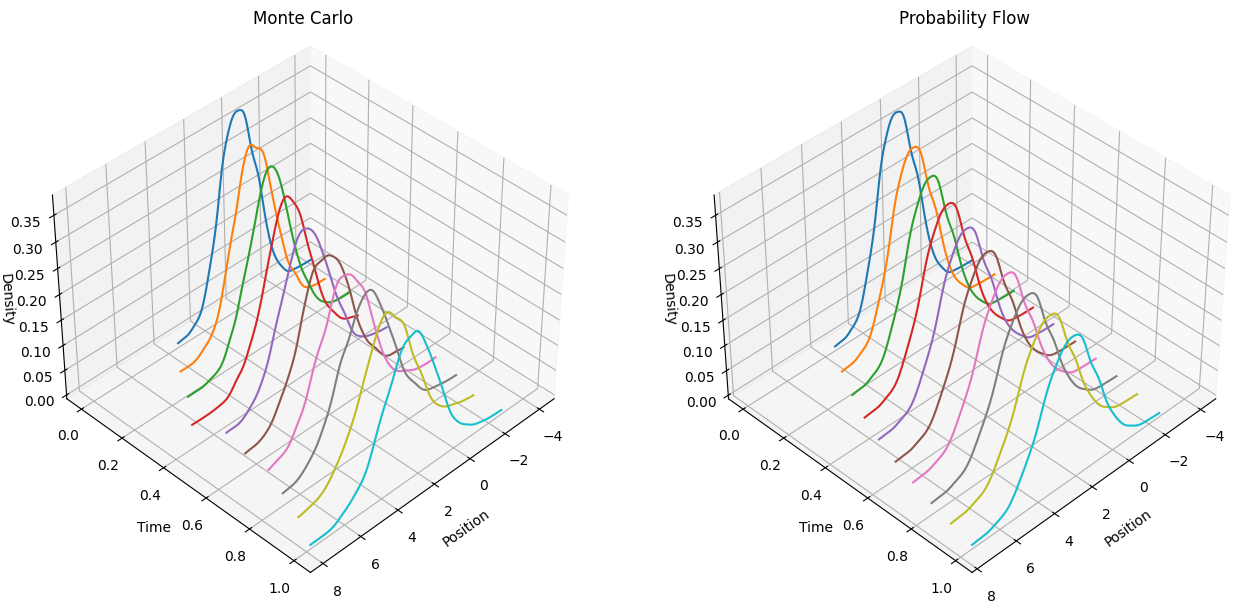

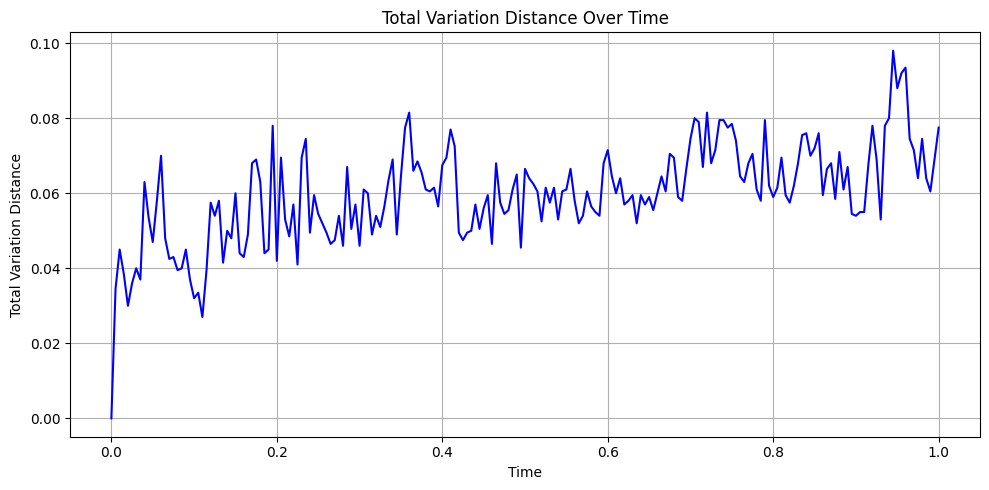

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm

def estimate_density(data_slice):
    kde = gaussian_kde(data_slice)
    x_range = np.linspace(data_slice.min(), data_slice.max(), 100)
    density = kde(x_range)
    return x_range, density

def calculate_histogram(data, bins):
    hist, _ = np.histogram(data, bins=bins, density=True)
    hist = hist / hist.sum()
    return hist

def total_variation(hist1, hist2):
    return np.sum(np.abs(hist1 - hist2)) 

fig = plt.figure(figsize=(20, 6))
time_indices = np.linspace(0, 200, 10, dtype=int)


ax1 = fig.add_subplot(131, projection='3d')
for t in time_indices:
    x, density = estimate_density(sdeLevy[:, t])
    ax1.plot(x, density, zs=t*0.005, zdir='y')
ax1.set_title('Monte Carlo')
ax1.set_xlabel('Position')
ax1.set_ylabel('Time')
ax1.set_zlabel('Density', labelpad=1)
ax1.view_init(elev=40, azim=45)


ax2 = fig.add_subplot(132, projection='3d')
for t in time_indices:
    x, density = estimate_density(learned_samples_np[t].squeeze())
    ax2.plot(x, density, zs=t*0.005, zdir='y')
ax2.set_title('Probability Flow')
ax2.set_xlabel('Position')
ax2.set_ylabel('Time')
ax2.set_zlabel('Density', labelpad=1)
ax2.view_init(elev=40, azim=45)

plt.tight_layout()

plt.savefig('/home/zqcai3/lcy/sbtm-levy/experiments/example1-probabilityflow.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



tv_errors = []
time_indices = np.linspace(0, 200, 200, dtype=int)
for t in time_indices:
    bins = np.linspace(min(sdeLevy[:, t].min(), learned_samples_np[t].min()), 
                       max(sdeLevy[:, t].max(), learned_samples_np[t].max()), 20)
    hist1 = calculate_histogram(sdeLevy[:, t], bins)
    hist2 = calculate_histogram(learned_samples_np[t].squeeze(), bins)
    tv_error = total_variation(hist1, hist2)
    tv_errors.append(tv_error)


plt.figure(figsize=(10, 5))
plt.plot(time_indices*0.005, tv_errors, linestyle='-', color='b')
plt.title('Total Variation Distance Over Time')
plt.xlabel('Time')
plt.ylabel('Total Variation Distance')
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/zqcai3/lcy/sbtm-levy/experiments/example1-TV.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

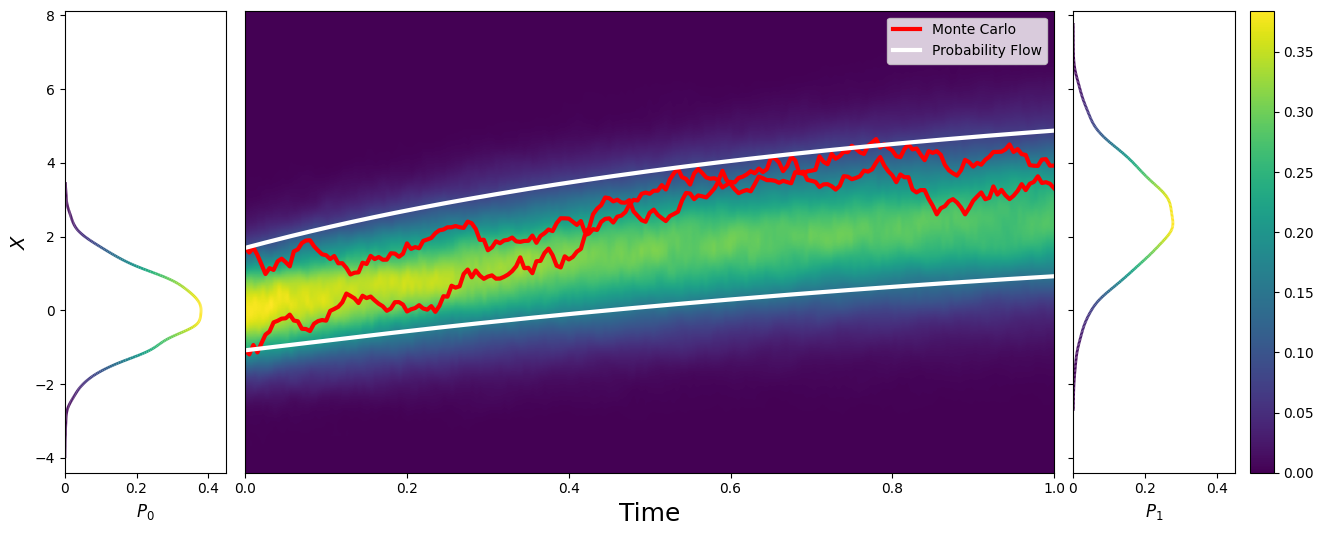

In [16]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


def create_line_segments(data, x_values):
    points = np.array([data, x_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def estimate_density(data):
    density = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 300)
    return xs, density(xs)

def format_func(value, tick_number):
    return int(value) if value == 0 else value

from matplotlib.ticker import FuncFormatter


np.random.seed(5)
data_learned =  np.hstack(learned_samples_np) 
data = sdeLevy
indices = np.random.choice(data.shape[0], 2, replace=False)
particles = data[indices]
particles_learned = data_learned[indices]


fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 5, 1])


ax_left = plt.subplot(gs[0])
x, density = estimate_density(data[:, 0])
segments = create_line_segments(density, x)
lc_left = LineCollection(segments, cmap=cm.viridis, norm=plt.Normalize(vmin=density.min(), vmax=density.max()))
lc_left.set_array(density)
lc_left.set_linewidth(2)
ax_left.add_collection(lc_left)
ax_left.set_ylim(data.min(),data.max())
ax_left.set_xlim(0,0.45)
ax_left.set_xlabel('$P_0$',fontsize=12)
ax_left.set_ylabel('$X$', fontsize=14)
ax_left.xaxis.set_major_formatter(FuncFormatter(format_func))

ax_center = plt.subplot(gs[1])
time_points = np.linspace(0, 1, 201)

for i, particle in enumerate(particles):
    if i == 0:
        ax_center.plot(time_points, particle, color='red', linewidth=3, label='Monte Carlo')
    else:
        ax_center.plot(time_points, particle, color='red', linewidth=3)

for i, particle in enumerate(particles_learned):
    if i == 0:
        ax_center.plot(time_points, particle, color='white', linewidth=3, label='Probability Flow')
    else:
        ax_center.plot(time_points, particle, color='white', linewidth=3)

density = np.vstack([gaussian_kde(data[:, i])(np.linspace(data.min(), data.max(), 300)) for i in range(data.shape[1])])
im = ax_center.imshow(density.T, aspect='auto', extent=[time_points.min(), time_points.max(), data.min(), data.max()], origin='lower', cmap='viridis')
ax_center.set_xlabel('Time',fontsize=18)
ax_center.legend(loc='upper right')
ax_center.set_yticks([])

ax_right = plt.subplot(gs[2])
x, density = estimate_density(data[:, -1])
segments = create_line_segments(density, x)
lc_right = LineCollection(segments, cmap=cm.viridis, norm=plt.Normalize(vmin=density.min(), vmax=density.max()))
lc_right.set_array(density)
lc_right.set_linewidth(2)
ax_right.add_collection(lc_right)
ax_right.set_ylim(data.min(),data.max())
ax_right.set_xlim(0,0.45)
ax_right.set_yticklabels([])
ax_right.set_xlabel('$P_1$',fontsize=12)
ax_right.xaxis.set_major_formatter(FuncFormatter(format_func))
cbar = fig.colorbar(im, ax=[ax_left, ax_center, ax_right], location='right')

plt.subplots_adjust(wspace=0.05,right=0.775)
plt.savefig('/home/zqcai3/lcy/sbtm-levy/experiments/example1-graph.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()